In [2]:
for i in range(5):
    !python tester.py

lol
lol
lol
lol
lol


In [1]:
import healpy as hp
from pathlib import Path
import vaex
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import animation

from scipy.optimize import minimize, curve_fit

from scipy import interpolate

import illustris_python as il

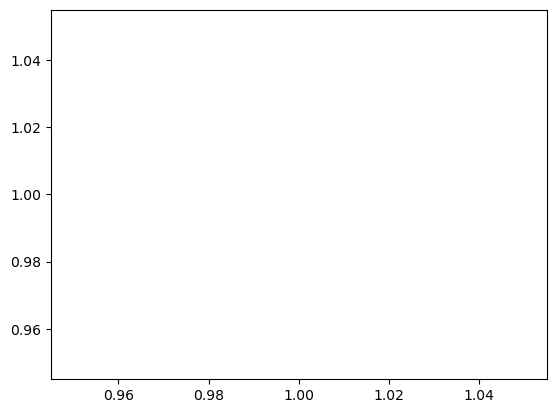

In [2]:
%matplotlib inline


plt.plot([1],[1])

font = {"weight": "normal", "size": 14}
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rc("font", **font)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
_legend = {"frameon": True, "framealpha":0.7}
plt.rc("legend", **_legend)
plt.show()

In [3]:
path = "/net/virgo01/data/users/spirov/Nexus Project/"

fields = ['SubhaloMass',] 
dm = il.snapshot.loadSubset(path,135,"dm")

In [4]:
dm_pos = dm["Coordinates"]
ids = dm["ParticleIDs"]

In [5]:
Xs = dm_pos[:,0]
Ys = dm_pos[:,1]
Zs = dm_pos[:,2]
Vx = dm["Velocities"][:,0]
Vy = dm["Velocities"][:,1]
Vz = dm["Velocities"][:,2]


df = vaex.from_arrays(ID = ids, X=Xs,Y=Ys,Z=Zs,Vx=Vx,Vy=Vy,Vz=Vz)

In [6]:
@vaex.register_function()
def correct(x):
    L = 75000
    return np.where(np.abs(x)>L/2, x-np.sign(x)*L,x)

def localizeDataFrame(absDf, x,y,z):
    rx = absDf.X - x
    ry = absDf.Y - y
    rz = absDf.Z - z
    
    L = 75000
    
    
    relx = rx.correct()
    rely = ry.correct()
    relz = rz.correct()
    
    
    relR = np.sqrt(relx**2 + rely**2+relz**2)
    #smolr = np.sqrt(relx**2 + rely**2)
    
    theta = np.arccos(relz/relR)
    fi = np.arctan2(rely,relx)
    
    relDf = absDf.copy()
    
    Vaway = (relx*absDf.Vx+rely*absDf.Vy+relz*absDf.Vz)/relR
    
    #print(relx)
   # print(fi)
    
    relDf["relx"] = relx
    relDf["rely"] = rely
    relDf["relz"] = relz
    
    relDf["R"] = relR
    relDf["Th"] = theta
    relDf["Fi"] = fi
    relDf["Vr"] = Vaway
    
    
    
    
    return relDf
    
    
    

In [7]:
cent = 37500
cdf = localizeDataFrame(df, cent,cent,cent)

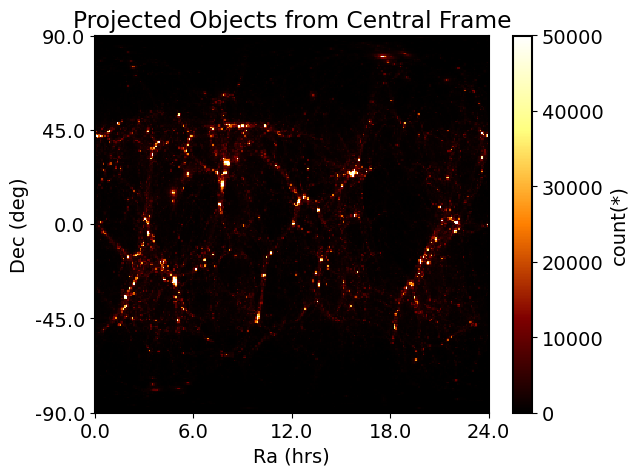

In [8]:
def projectSky(df,name="Relative Frame"):
    df.viz.heatmap("Fi","Th",vmin=0,vmax=50000)
    plt.xlabel("Ra (hrs)")
    plt.ylabel("Dec (deg)")
    plt.yticks(np.linspace(0,np.pi,5), np.linspace(-90,90,5))
    plt.xticks(np.linspace(-np.pi,np.pi,5), np.linspace(0,24,5))
    plt.title(f"Projected Objects from {name}")
    plt.show()
    

projectSky(cdf,"Central Frame")

# Healpy

In [9]:
cart_proj=hp.projector.CartesianProj()
sp_proj=hp.projector.SphericalProj()

In [10]:
f = cdf.Fi.values
th = cdf.Th.values

In [11]:
the, ph = cart_proj.xy2ang(f,th)

In [12]:
nside = 64
hp_map = np.zeros(hp.nside2npix(nside))
pixel_indices = hp.ang2pix(nside, the, ph)

In [13]:
cdf

#,ID,X,Y,Z,Vx,Vy,Vz,relx,rely,relz,R,Th,Fi,Vr
0,88038007,860.2786,26320.94,18281.758,37.119167,-126.95646,-137.56683,-36639.72265625,-11179.060546875,-19218.2421875,42857.68896960056,1.1057995315154274,-1.8669324481887126,63.06944528375522
1,88173007,862.8968,26320.16,18283.193,-62.20938,-280.38562,-148.18048,-36637.1015625,-11179.83984375,-19216.806640625,42855.00772717244,1.1058056201520665,-1.866971876038315,192.77544981653008
2,3638407,859.6459,26324.168,18280.25,79.16669,-229.4381,-60.910133,-36640.35546875,-11175.83203125,-19219.75,42858.064124847864,1.105764561957647,-1.8668470155909385,19.462932161028494
3,3439732,861.843,26322.36,18286.85,-63.35342,-266.66763,-153.27612,-36638.15625,-11177.640625,-19213.150390625,42853.696354851796,1.10588572069254,-1.8669089267493915,192.4404516730346
4,81301332,860.39545,26319.984,18284.232,187.94035,-223.2462,-114.28199,-36639.60546875,-11180.015625,-19215.767578125,42856.72831536979,1.1058528857661452,-1.8669571876460318,-51.19728725349054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"94,196,370",94196367,59066.92,45572.824,27697.115,-60.46998,14.100099,-88.42843,21566.921875,8072.82421875,-9802.884765625,25027.967551467555,1.168342577469785,1.2126262641474959,-12.924340908224453
"94,196,371",94196368,63540.31,51048.69,47286.035,195.7977,257.62384,118.035645,26040.30859375,13548.69140625,9786.03515625,30942.3850819371,1.8925875514014152,1.0910433702839757,314.9142949409681
"94,196,372",94196369,60536.855,49059.383,56893.633,88.98358,148.74493,-175.3597,23036.85546875,11559.3828125,19393.6328125,32255.68220577692,2.2158571237737115,1.1057274839895157,11.422483513168501
"94,196,373",94196373,65776.43,61606.74,46854.918,242.84515,16.739655,113.39123,28276.4296875,24106.73828125,9354.91796875,38317.173651443256,1.8174334764577948,0.8648305139592483,217.42464872433405


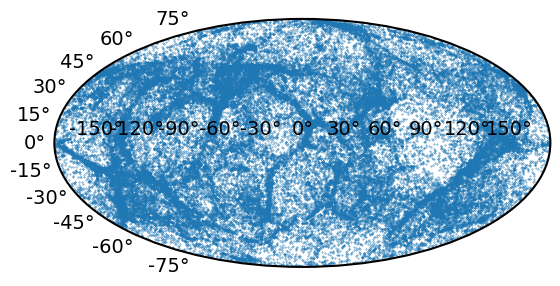

In [33]:
plt.subplot(projection="mollweide")
plt.scatter(f[::1000],th[::1000]-np.pi/2,s=0.1)
plt.show()